In [1]:
import time
import nltk
from nltk.corpus import brown
from nltk.corpus import stopwords
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import spatial
import matplotlib.pyplot as plt

nltk.download('brown')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\swara\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\swara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
corpus = brown.sents()

In [4]:
stop_words = set(stopwords.words('english'))
corpus = [[word for word in sent if word.lower() not in stop_words] for sent in corpus]

# Remove punctuation from corpus
from string import punctuation
corpus = [[word for word in sent if word not in punctuation] for sent in corpus]

# Remove empty sentences
corpus = [sent for sent in corpus if len(sent) > 0]

# Remove sentences with less than 5 words
corpus = [sent for sent in corpus if len(sent) >= 5]

# Remove sentences with more than 20 words
corpus = [sent for sent in corpus if len(sent) <= 20]

# Remove rare words
from collections import Counter
word_freq = Counter([word for sent in corpus for word in sent])
corpus = [[word for word in sent if word_freq[word] > 5] for sent in corpus]

In [5]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['personality',
 'crossing',
 'naturally',
 'unbroken',
 'Cranston',
 'linguist',
 'speaking',
 'Dolores',
 'slippers',
 'Control',
 'induced',
 'wagon',
 'workings',
 'Republic',
 'vector',
 'arch',
 'bent',
 'animals',
 'columns',
 'elastic',
 'voices',
 'heavy',
 'endurance',
 'tremendous',
 'missiles',
 'coast',
 'cards',
 'Rachel',
 'solidarity',
 'newborn',
 'absolutely',
 'epidemic',
 'duty',
 'occurs',
 'desires',
 'narrative',
 'planetary',
 'Diane',
 'rocks',
 'largest',
 'Douglass',
 'twenty',
 'Family',
 'shoulder',
 'Theatre',
 'neatly',
 'progress',
 'suffering',
 'reactionary',
 'Juniors',
 'pamphlets',
 'Russians',
 'ones',
 'burned',
 'approximately',
 'frontier',
 "Fromm's",
 'narrow',
 'masterpiece',
 'caused',
 'Napoleon',
 'Cologne',
 'reasoning',
 'raised',
 'commonplace',
 'beams',
 'towns',
 'conducted',
 'impressions',
 'six',
 'urge',
 'administered',
 'housing',
 'Mantle',
 'Together',
 'drift',
 'fronts',
 'wish',
 'shell',
 'devoting',
 'chromatic',
 'grows

In [6]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'personality': 0, 'crossing': 1, 'naturally': 2, 'unbroken': 3, 'Cranston': 4, 'linguist': 5, 'speaking': 6, 'Dolores': 7, 'slippers': 8, 'Control': 9, 'induced': 10, 'wagon': 11, 'workings': 12, 'Republic': 13, 'vector': 14, 'arch': 15, 'bent': 16, 'animals': 17, 'columns': 18, 'elastic': 19, 'voices': 20, 'heavy': 21, 'endurance': 22, 'tremendous': 23, 'missiles': 24, 'coast': 25, 'cards': 26, 'Rachel': 27, 'solidarity': 28, 'newborn': 29, 'absolutely': 30, 'epidemic': 31, 'duty': 32, 'occurs': 33, 'desires': 34, 'narrative': 35, 'planetary': 36, 'Diane': 37, 'rocks': 38, 'largest': 39, 'Douglass': 40, 'twenty': 41, 'Family': 42, 'shoulder': 43, 'Theatre': 44, 'neatly': 45, 'progress': 46, 'suffering': 47, 'reactionary': 48, 'Juniors': 49, 'pamphlets': 50, 'Russians': 51, 'ones': 52, 'burned': 53, 'approximately': 54, 'frontier': 55, "Fromm's": 56, 'narrow': 57, 'masterpiece': 58, 'caused': 59, 'Napoleon': 60, 'Cologne': 61, 'reasoning': 62, 'raised': 63, 'commonplace': 64, 'beams':

In [7]:
#vocab size
voc_size = len(vocab)
print(voc_size)

10582


In [8]:
#append UNK
vocab.append('<UNK>')

In [9]:
vocab

['personality',
 'crossing',
 'naturally',
 'unbroken',
 'Cranston',
 'linguist',
 'speaking',
 'Dolores',
 'slippers',
 'Control',
 'induced',
 'wagon',
 'workings',
 'Republic',
 'vector',
 'arch',
 'bent',
 'animals',
 'columns',
 'elastic',
 'voices',
 'heavy',
 'endurance',
 'tremendous',
 'missiles',
 'coast',
 'cards',
 'Rachel',
 'solidarity',
 'newborn',
 'absolutely',
 'epidemic',
 'duty',
 'occurs',
 'desires',
 'narrative',
 'planetary',
 'Diane',
 'rocks',
 'largest',
 'Douglass',
 'twenty',
 'Family',
 'shoulder',
 'Theatre',
 'neatly',
 'progress',
 'suffering',
 'reactionary',
 'Juniors',
 'pamphlets',
 'Russians',
 'ones',
 'burned',
 'approximately',
 'frontier',
 "Fromm's",
 'narrow',
 'masterpiece',
 'caused',
 'Napoleon',
 'Cologne',
 'reasoning',
 'raised',
 'commonplace',
 'beams',
 'towns',
 'conducted',
 'impressions',
 'six',
 'urge',
 'administered',
 'housing',
 'Mantle',
 'Together',
 'drift',
 'fronts',
 'wish',
 'shell',
 'devoting',
 'chromatic',
 'grows

In [10]:
word2index['<UNK>'] = 0

In [11]:
index2word = {v:k for k, v in word2index.items()} 

In [12]:
for c in corpus:
    print(c)

['Fulton', 'County', 'Grand', 'said', 'Friday', 'investigation', 'recent', 'primary', 'election', 'produced', '``', 'evidence', "''", 'took', 'place']
['jury', 'said', 'City', 'Executive', 'Committee', 'over-all', 'charge', 'election', '``', 'deserves', 'praise', 'thanks', 'City', 'Atlanta', "''", 'manner', 'election', 'conducted']
['``', 'relative', 'handful', 'reports', 'received', "''", 'jury', 'said', '``', 'considering', 'widespread', 'interest', 'election', 'number', 'voters', 'size', 'city', "''"]
['jury', 'said', 'find', 'many', "Georgia's", 'registration', 'election', 'laws', '``', 'inadequate', 'often', 'ambiguous', "''"]
['recommended', 'Fulton', 'legislators', 'act', '``', 'laws', 'studied', 'revised', 'end', 'improving', "''"]
['However', 'jury', 'said', 'believes', '``', 'two', 'offices', 'combined', 'achieve', 'greater', 'efficiency', 'reduce', 'cost', 'administration', "''"]
['City', 'Department', 'jury', 'said', '``', 'lacking', 'experienced', 'clerical', 'personnel', 

In [13]:
def random_batch(batch_size, word_sequence, window_size=2):
    
    # Make skip gram of dynamic window size with default size of 2
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - j]] for j in range(1, window_size + 1) if i - j > 0] + [word2index[sent[i + j]] for j in range(1, window_size + 1) if i + j < len(sent)]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

In [14]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)    
            
        return nll # negative log likelihood

In [15]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Skipgram(voc_size, embedding_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 10583])

In [17]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
num_epochs = 1000
start = time.time()

for epoch in range(num_epochs):
    
    window_size = np.random.randint(2, 7)
    
    input_batch, target_batch = random_batch(batch_size, corpus, window_size)
    input_batch  = torch.LongTensor(input_batch)  
    target_batch = torch.LongTensor(target_batch)

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)
    
    loss.backward()
    optimizer.step()
    
    epoch_mins, epoch_secs = epoch_time(start, time.time())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 100 | cost: 10.711563 | time: 4m 37s
Epoch: 200 | cost: 9.055941 | time: 9m 19s
Epoch: 300 | cost: 9.288723 | time: 14m 7s
Epoch: 400 | cost: 10.474367 | time: 18m 45s
Epoch: 500 | cost: 11.159386 | time: 23m 23s
Epoch: 600 | cost: 10.314670 | time: 28m 8s
Epoch: 700 | cost: 9.500047 | time: 32m 53s
Epoch: 800 | cost: 11.739166 | time: 37m 34s
Epoch: 900 | cost: 10.519543 | time: 42m 15s
Epoch: 1000 | cost: 10.059761 | time: 47m 9s


In [19]:
#list of vocabs
vocab[:10]

['personality',
 'crossing',
 'naturally',
 'unbroken',
 'Cranston',
 'linguist',
 'speaking',
 'Dolores',
 'slippers',
 'Control']

In [20]:
word = vocab[0]

In [21]:
#numericalization
id = word2index[word]
id

0

In [22]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [23]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[ 0.5004, -0.4017]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.2380, -0.5722]], grad_fn=<EmbeddingBackward0>))

In [24]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.4870, grad_fn=<SelectBackward0>)

In [25]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

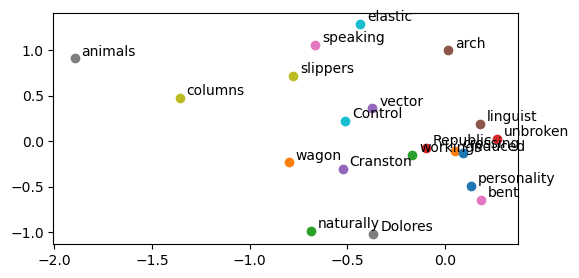

In [26]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [27]:
vocab

['personality',
 'crossing',
 'naturally',
 'unbroken',
 'Cranston',
 'linguist',
 'speaking',
 'Dolores',
 'slippers',
 'Control',
 'induced',
 'wagon',
 'workings',
 'Republic',
 'vector',
 'arch',
 'bent',
 'animals',
 'columns',
 'elastic',
 'voices',
 'heavy',
 'endurance',
 'tremendous',
 'missiles',
 'coast',
 'cards',
 'Rachel',
 'solidarity',
 'newborn',
 'absolutely',
 'epidemic',
 'duty',
 'occurs',
 'desires',
 'narrative',
 'planetary',
 'Diane',
 'rocks',
 'largest',
 'Douglass',
 'twenty',
 'Family',
 'shoulder',
 'Theatre',
 'neatly',
 'progress',
 'suffering',
 'reactionary',
 'Juniors',
 'pamphlets',
 'Russians',
 'ones',
 'burned',
 'approximately',
 'frontier',
 "Fromm's",
 'narrow',
 'masterpiece',
 'caused',
 'Napoleon',
 'Cologne',
 'reasoning',
 'raised',
 'commonplace',
 'beams',
 'towns',
 'conducted',
 'impressions',
 'six',
 'urge',
 'administered',
 'housing',
 'Mantle',
 'Together',
 'drift',
 'fronts',
 'wish',
 'shell',
 'devoting',
 'chromatic',
 'grows

In [28]:
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [29]:
def cos_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.9895340818330554
cat vs. animal:  0.6175882445241667
cat vs. cat:  1.0000000000000002


In [30]:
def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.9895340818330554
cat vs. animal:  0.6175882445241666
cat vs. cat:  1.0
